# Landkreis: Weekly Cases + Deaths Model

## ToDo
* add uncertainty to mortality rate
* add reporting factor to death curve too
* multiple age groups
* use Refdata instead of Meldedatum
* try out scaling

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm
from os import walk
from scipy.stats import lognorm
from scipy import stats as sps
import xarray as xr
from matplotlib.ticker import MultipleLocator

In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now().date() - timedelta(days=1)

In [3]:
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum', 'Refdatum'])
df_rki = df_raw.copy()
#df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])
#df_rki['Refdatum'] = pd.to_datetime(df_rki['Refdatum'])
df_rki['week'] = df_rki['Meldedatum'].dt.week
df_rki['ref_week'] = df_rki['Refdatum'].dt.week
df_rki = df_rki.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')
df_rki['Meldeverzug'] = (df_rki['Meldedatum'] - df_rki['Refdatum']).dt.days

f"Found {df_rki['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

'Found 179,305 cases downloaded at 2020-05-27_22h'

In [4]:
df_rki[:3]

,Unnamed: 0,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,week,ref_week,Meldeverzug
0,0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,9098623,2020-03-14,...,0,-9,2020-03-16,0,1,1,Nicht übermittelt,11,12,-2
1,1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,9098624,2020-03-19,...,0,-9,2020-03-13,0,1,1,Nicht übermittelt,12,11,6
2,2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,9098625,2020-03-19,...,0,-9,2020-03-16,0,1,1,Nicht übermittelt,12,12,3


In [5]:
ham = df_rki.query("Landkreis == 'SK Hamburg'").groupby(['Altersgruppe', 'ref_week'])[['AnzahlFall', 'AnzahlTodesfall']].sum()
for age_group in age_groups:
    ham.loc[age_group, 'AnzahlFall'].plot(figsize=[10,3])
    ax = plt.gca()
    ax.set_ylim([0, 500])
    ax2 = ax.twinx()
    ham.loc[age_group, 'AnzahlTodesfall'].plot(ax=ax2, color='C1')
    ax2.set_ylim([0, 50])
    plt.title(age_group)
    plt.show()

NameError: name 'age_groups' is not defined

In [ ]:
ham = df_rki.query("Landkreis == 'SK Köln'").groupby(['Altersgruppe', 'ref_week'])[['AnzahlFall', 'AnzahlTodesfall']].sum()
for age_group in age_groups:
    ham.loc[age_group, 'AnzahlFall'].plot(figsize=[10,3])
    ax = plt.gca()
    ax.set_ylim([0, 500])
    ax2 = ax.twinx()
    ham.loc[age_group, 'AnzahlTodesfall'].plot(ax=ax2, color='C1')
    ax2.set_ylim([0, 50])
    plt.title(age_group)
    plt.show()

In [ ]:
df_rki['Landkreis'].nunique()

In [6]:
df_rki['Altersgruppe'].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [7]:
days_per_week = df_rki[['week', 'Meldedatum']].drop_duplicates()
weeks_ending = days_per_week.groupby('week')['Meldedatum'].max().reset_index()
weeks_ending.columns = ['week', 'last_dow']
weeks_ending = weeks_ending.set_index('week')['last_dow']
weeks_ending.name = 'Last Day of Week'

n_days = days_per_week.groupby('week').size()
complete = n_days[n_days == 7]
max_complete_week = complete.index.max()
first_death_week = df_rki.query('AnzahlTodesfall > 0')['week'].min()
first_death_week, max_complete_week

(10, 21)

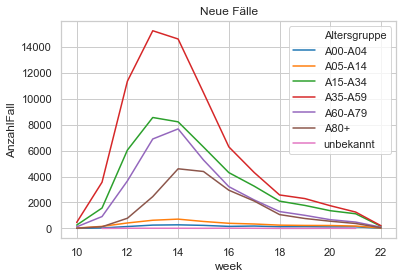

In [8]:
weekly_totals = df_rki.query('week >= @first_death_week')\
                     .groupby(['week', 'Altersgruppe'])[['AnzahlFall']].sum()

sns.lineplot(x='week',y='AnzahlFall', hue='Altersgruppe', data=weekly_totals.reset_index())
plt.title('Neue Fälle');

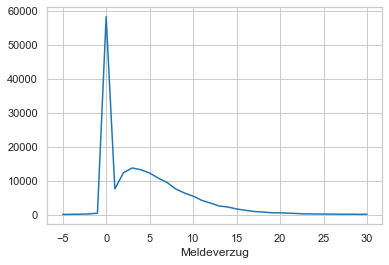

In [9]:
from matplotlib import ticker

case_weighted = df_rki.groupby('Meldeverzug')['AnzahlFall'].sum()
case_weighted.loc[-5:30].plot()

## Refdatum vs Meldedatum

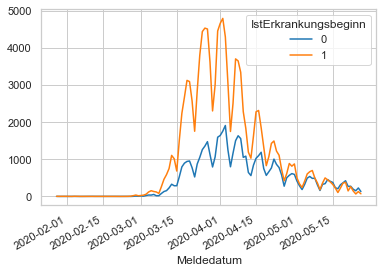

In [10]:
by_begin = df_rki.groupby(['Meldedatum', 'IstErkrankungsbeginn'])['AnzahlFall'].sum().reset_index()
by_begin = by_begin.pivot(index='Meldedatum', columns='IstErkrankungsbeginn', values='AnzahlFall').fillna(0)
by_begin.plot()

## Epidemilogical paramters

*Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data* Linton, Kobayashi, et al. 17th of Feb

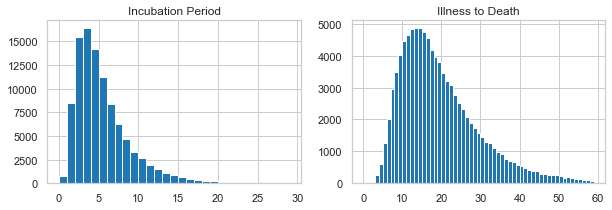

In [11]:
incubation = np.random.lognormal(1.525, .625, size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(incubation, bins=range(30))
axes[0].set_title('Incubation Period')
death = np.random.lognormal(2.865, .533, size=100000)
axes[1].hist(death, bins=range(60))
_= axes[1].set_title('Illness to Death')

In [12]:
# generation time
# Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing Ferretti, Fraser et al.

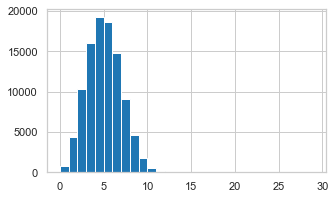

In [13]:
gen_time = np.random.weibull(2.826, size=100000) *  5.665
plt.figure(figsize=(5,3))
_= plt.hist(gen_time, bins=range(30))

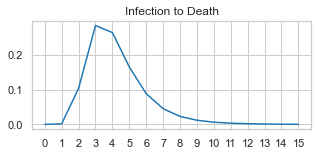

In [14]:
def lognorm_frame(mu, sigma):
    incubation_time = lognorm(s=sigma, scale=np.exp(mu))
    cdf = pd.Series(incubation_time.cdf(range(90)))
    daily_p = cdf - cdf.shift(1).fillna(0)
    return daily_p

cum_inc_time = lognorm_frame(1.525, 0.625)[:22]
cum_tt_death = lognorm_frame(2.865, 0.533)

def to_weekly_dist(dist):
    week_starts = np.array(range(0,len(dist) + 1, 7))
    cum_dist = dist.cumsum() / dist.sum()
    weekly = (cum_dist[week_starts] - cum_dist[week_starts].shift(1).fillna(0))
    weekly.index = (weekly.index / 7).astype(int)
    return weekly

infection_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
to_weekly_dist(infection_to_death).plot(figsize=(5,2))
plt.title('Infection to Death')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [15]:
inf_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
for  i in range(3, 8):
    print(f'{inf_to_death.cumsum()[i * 7]:.0%} of deaths during first {i} weeks')

39% of deaths during first 3 weeks
65% of deaths during first 4 weeks
81% of deaths during first 5 weeks
90% of deaths during first 6 weeks
94% of deaths during first 7 weeks


### 90% of deaths happen in the first 6 weeks after infection

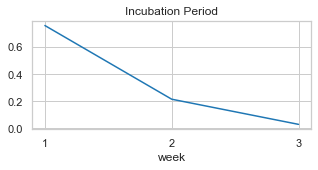

In [16]:
weekly_incubation = to_weekly_dist(cum_inc_time)
weekly_incubation[1:].plot(figsize=(5,2))
plt.title('Incubation Period')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('week');

In [17]:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})

In [18]:
kreise = df_rki.groupby('Landkreis')['AnzahlTodesfall'].sum().sort_values(ascending=False)
kreise[kreise.index.str.startswith('SK B')]
kreise['LK Pinneberg'], kreise['SK Berlin Friedrichshain-Kreuzberg']

(43, 6)

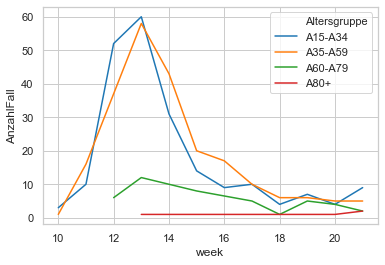

In [19]:
cases_by_age = df_rki.query("week <= @max_complete_week and Landkreis == 'SK Berlin Friedrichshain-Kreuzberg'")\
                     .groupby(['Altersgruppe', 'week'])['AnzahlFall'].sum()\
                     .reset_index()
to_drop = cases_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
cases_by_age = cases_by_age[~to_drop]
sns.lineplot(x='week', y='AnzahlFall', hue='Altersgruppe', data=cases_by_age)

Dropped age groups: 


Altersgruppe
A00-A04    0
A05-A14    0
Name: AnzahlTodesfall, dtype: int64

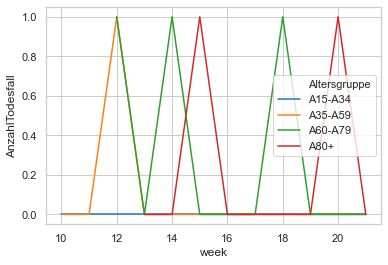

In [20]:
complete_weeks = df_rki.query("week >= @first_death_week and week <= @max_complete_week and Landkreis == 'SK Berlin Friedrichshain-Kreuzberg'")
deaths_by_age = complete_weeks.groupby(['week', 'Altersgruppe'])['AnzahlTodesfall'].sum().reset_index()
to_drop = deaths_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
print('Dropped age groups: ')
display(deaths_by_age[to_drop].groupby('Altersgruppe')['AnzahlTodesfall'].sum())
deaths_by_age['cartesian_key'] = True

deaths_by_age = deaths_by_age[~to_drop]
_= sns.lineplot(x='week', y='AnzahlTodesfall', hue='Altersgruppe', data=deaths_by_age)

## Bayesian cases based on deaths

In [21]:
min_death_week_2 = deaths_by_age.query('AnzahlTodesfall > 0')['week'].min()
# start death data with first week where there are still 0 deaths.
death_start_week = min_death_week_2 - 1

# allow time for cases to lead to deaths at week min_death_week
start_offset = 2
start_week = death_start_week - start_offset
# deaths from last week might not be reported yet
death_end_week = max_complete_week - 5
n_death_weeks = death_end_week - death_start_week + 1
n_weeks = max_complete_week - start_week + 1
print(f'n_weeks: {n_weeks}, start_week: {start_week}')
f'death_start_week: {death_start_week}, death_end_week: {death_end_week}, n_death_weeks: {n_death_weeks}'

n_weeks: 13, start_week: 9


'death_start_week: 11, death_end_week: 16, n_death_weeks: 6'

In [22]:
# this lower triangular matirx vectorizes the multiplication with r,
# which is composed of a starting value r_zero and it's changes over
# the following time points
TRIL = []
for i in range(1, n_weeks):
    row = list(range(1, i+1))
    row.reverse()
    n_zeros = n_weeks - i - 1
    if n_zeros > 0:
        row = np.concatenate([row, np.zeros(n_zeros)])
    TRIL.append(row[:16])
TRIL = np.array(TRIL)
print(TRIL.shape)
TRIL[:3,:3]

(12, 12)


array([[1., 0., 0.],
       [2., 1., 0.],
       [3., 2., 1.]])

In [23]:
def create_delay_matrix(delay):
    def pad_delay_series(delay):
        if n_weeks > delay.shape[0]:
            padded_delay = np.concatenate([delay.values, 
                                           np.zeros(n_weeks - delay.shape[0])])
        else:
            padded_delay = delay.values[:n_weeks]
        padded_delay = pd.Series(padded_delay)
        return padded_delay
    padded_delay = pad_delay_series(delay)
    res = [padded_delay.shift(i).fillna(0).values for i in range(n_weeks)]
    return np.array(res).T

DD = create_delay_matrix(weekly_incubation)
# n_weeks, n_weeks
print(DD.shape)
DD[:3,:3]

(13, 13)


array([[0.        , 0.        , 0.        ],
       [0.75535453, 0.        , 0.        ],
       [0.21460865, 0.75535453, 0.        ]])

In [24]:
age_groups = mortality['Altersgruppe']
grouped = df_rki.query("week >= @start_week and "
                       "week <= @max_complete_week and "
                       "Altersgruppe in @age_groups") \
                .groupby(['week', 'Landkreis', 'Altersgruppe'])[['AnzahlFall', 'AnzahlTodesfall']] \
                .sum() \
                .unstack('Altersgruppe')
# we are unstacking Altersgruppe first, so that all Lankreise have all Altergruppen 
grouped = grouped.unstack('Landkreis') \
                 .swaplevel(1,2, axis=1) \
                 .fillna(0) \
                 .sort_index(axis=1, level=[0,1,2])
# all Landkreise have the same number of Altersgruppen
assert grouped.stack(level=[1,2]).groupby(['Landkreis', 'week']).size().value_counts().shape[0] == 1
grouped[:3]

AnzahlFall                                                    \
Landkreis    LK Ahrweiler                      LK Aichach-Friedberg           
Altersgruppe      A15-A34 A35-A59 A60-A79 A80+              A15-A34 A35-A59   
week                                                                          
9                     0.0     0.0     0.0  0.0                  0.0     0.0   
10                    0.0     0.0     0.0  0.0                  1.0     0.0   
11                    3.0     6.0     1.0  0.0                  0.0     4.0   

                                                      ... AnzahlTodesfall  \
Landkreis                 LK Alb-Donau-Kreis          ...     SK Würzburg   
Altersgruppe A60-A79 A80+            A15-A34 A35-A59  ...         A60-A79   
week                                                  ...                   
9                0.0  0.0                0.0     1.0  ...             0.0   
10               0.0  0.0                1.0     3.0  ...             0.0   
11               1.0  1.0                2.0    10.0  ...             0.0   

                                                                          \
Landkreis         SK Zweibrücken                      StadtRegion Aachen   
Altersgruppe A80+        A15-A34 A35-A59 A60-A79 A80+            A15-A34   
week                                                                       
9             0.0            0.0     0.0     0.0  0.0                0.0   
10            0.0            0.0     0.0     0.0  0.0                0.0   
11            7.0            0.0     0.0     0.0  0.0                0.0   

                                   
Landkreis                          
Altersgruppe A35-A59 A60-A79 A80+  
week                               
9                0.0     0.0  0.0  
10               0.0     0.0  0.0  
11               1.0     1.0  2.0  

[3 rows x 3296 columns]

#### Select counties to include

In [30]:
n_mids = 20
mid_diff = int(n_mids / 2)

sum_of_cases = grouped['AnzahlFall'].groupby(level=0, axis=1).sum().sum().sort_values()
mins = sum_of_cases.iloc[:3]
maxs = sum_of_cases.iloc[range(-1, -4, -1)]
mids = sum_of_cases.iloc[200-mid_diff:200+mid_diff]
sel_counties = ['SK Berlin Friedrichshain-Kreuzberg', 'SK Berlin Neukölln', 'LK Pinneberg', 'LK Recklinghausen']
sel_counties = pd.concat([maxs, mins, mids]).index.tolist() + sel_counties
cases = grouped['AnzahlFall'].loc[:, sel_counties]
deaths = grouped['AnzahlTodesfall'].loc[death_start_week:death_end_week, sel_counties]
cases.shape, deaths.shape

((13, 120), (6, 120))

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

Let $\gamma$ be ther inverse of the generation time. We model the number of $deaths(t)$ for people who got infected at time $t$.
$$ 
\begin{eqnarray}
\text{new infections}(t) &:=& \text{new infections}(t-1) \cdot e^{\gamma (r(t) -1)} \\
\operatorname{log}(\text{new infections})(t) &=& \operatorname{log}(\text{new infections}(t-1)) + \gamma (r(t) -1) \\
\text{expected cases}(t) &:=& \text{DelayMatrix} \cdot \text{new infections}(t) \\
\text{new deaths}(t) &:=& \operatorname{Normal}(\text{expected cases}(t) \cdot \text{mortality}(t))
\end{eqnarray}
$$

For each county (Landkreis) we draw a mean growth rate $r_L(t)$ and each age group gets a growth rate $r_{L,a}(t)$ drawn from a narrow distribution around $r_L(t)$. 

We model a case reporting rate $\text{rep}_L(t)$ per county drawn from a shared distribution $\text{rep}(t)$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

In [31]:
n_age_groups = age_groups.shape[0]
n_counties = int(cases.shape[1] / n_age_groups)
n_age_groups, n_counties

(4, 30)

In [32]:
import theano

# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# in weeks
serial_interval = 6/7

# shape = weeks, (counties, age_groups)

with pm.Model() as model:
    # r[0] 
    # county priors
    r_l_zero_mu = pm.Normal('r_l_zero_mu', np.log(3), .1)
    r_l_zero_sigma = pm.Gamma('r_l_zero_sigma', mu=0.5, sigma=.1)
    r_l_zero = pm.Normal('r_l_zero', r_l_zero_mu, r_l_zero_sigma, shape=n_counties)

    # age groups in counties
    r_la_zero_sigma = pm.Gamma('r_la_zero_sigma', mu=0.3, sigma=.1)
    r_la_zero = pm.Normal('r_la_zero_inner', r_l_zero, r_la_zero_sigma, shape=(n_age_groups, n_counties)) \
                    .T.reshape([1, n_age_groups * n_counties])
    
    # r[1:]
    # county priors
    r_l_delta_mu = pm.Normal('r_l_delta_mu', 0, .1, shape=n_weeks-2)
    r_l_delta_sigma = pm.Gamma('r_l_delta_sigma', mu=0.7, sigma=.15, shape=n_weeks-2)
    r_l_delta = pm.Normal('r_l_delta', r_l_delta_mu, r_l_delta_sigma, shape=(n_counties, n_weeks-2))
    # age groups in counties
    r_la_delta_sigma = pm.Gamma('r_la_delta_sigma', mu=0.4, sigma=.1, shape=n_weeks-2)
    r_la_delta = pm.Normal('r_la_delta', r_l_delta, r_la_delta_sigma, shape=(n_age_groups, n_counties, n_weeks-2)) \
                   .T.reshape([n_weeks-2, n_age_groups * n_counties])
    
    # shape (n_weeks-1, n_age_groups * n_counties)
    r_la = pm.Deterministic('r_la', pm.math.concatenate([r_la_zero, r_la_delta], axis=0))
    
    # start values for weekly new infections
    # county priors
    start_inf_l_mu = pm.Normal('start_inf_l_mu', mu=1, sigma=2)
    start_inf_l_sigma = pm.Gamma('start_inf_l_sigma', mu=0.6, sigma=.2)
    start_inf_l = pm.Normal('start_inf_l', start_inf_l_sigma, shape=n_counties)
    # age groups in counties
    start_inf_l_a_simga = pm.Gamma('start_inf_l_a_simga', mu=0.4, sigma=.1)
    start_inf_l_a = pm.Normal('start_inf_l_a', start_inf_l, start_inf_l_a_simga, shape=(n_age_groups, n_counties)) \
                      .T.reshape([1, n_age_groups * n_counties])
    
    
    # TODO: make the growth a logit
    # use matrix TRIL to vectorize the stepwise linear growth of the log_infections
    log_infection_following = start_inf_l_a + pm.math.dot(TRIL, r_la / serial_interval)
    log_infections = pm.Deterministic('log_infections', 
        pm.math.concatenate([start_inf_l_a, log_infection_following], axis=0))
    print(f'shape of log_infection {log_infections.tag.test_value.shape}')
    
    # expected cases
    # the death delay matrix DD spreads infections out into the future 
    # weighted by the time to death probability on a future day
    expected_cases = pm.Deterministic('expected_cases', pm.math.dot(DD, np.exp(log_infections)))
    print(f'shape of expected_cases {expected_cases.tag.test_value.shape}')
    
    
    # case reporting rate
    case_rep_rate_zero = pm.Beta('case_rep_rate_zero', mu=0.3, sigma=0.1)
    case_rep_rate_zero_l = pm.Beta('case_rep_rate_zero_l', mu=case_rep_rate_zero, sigma=.05, shape=n_counties)
    
    # the change in reporting rate should get less over time
    rep_rate_change = 1 / (5 + np.arange(1, n_weeks-1))
    print(f'rep_rate_change: {rep_rate_change}')
    rep_rate_change_over_time = pm.Gamma('rep_rate_change_over_time', mu=rep_rate_change, sigma=0.05, shape=(n_weeks-2))
    case_rep_rate_factors_l = pm.Gamma('case_rep_rate_factors_l', 
                                       mu=1, 
                                       sigma=rep_rate_change_over_time,
                                       shape=(n_counties, n_weeks-2)).T
    
    log_case_rep_rate = np.log(pm.math.concatenate([case_rep_rate_zero_l.reshape([1, n_counties]),
                                                    case_rep_rate_factors_l]))
    REP_TRIL = np.tril(np.ones(n_weeks-1))
    case_rep_rates = np.exp(pm.math.dot(REP_TRIL, log_case_rep_rate))
    case_rep_rates = pm.Deterministic('case_rep_rates', np.repeat(case_rep_rates, 4, axis=1))

       
    # reported cases
    # the week of the first infections we still don't have cases, because of the incubation period
    reported_cases = pm.Normal('reported_cases', 
                                expected_cases[1:] * case_rep_rates, 
                                # sqrt(expected_cases) would approximate a Poisson distribution
                                # we add additional variance here as we want the deaths to be the 
                                # primary source of information and cases only secondary
                                np.power(expected_cases[1:] * case_rep_rates, 0.7) * 2 + 5, 
                                shape=(n_weeks-1, n_age_groups * n_counties),
                                observed=cases[1:])
    
    # deaths
    repeated_mortalities = np.tile(mortality.sort_values('Altersgruppe')['mortality'], n_counties)
    expected_deaths = pm.Deterministic('expected_deaths', 
                                       expected_cases * repeated_mortalities)[start_offset:start_offset+n_death_weeks]
    obs_deaths = pm.Normal('obs_deaths', 
                            expected_deaths,
                            sigma=np.sqrt(expected_deaths),
                            shape=n_weeks, 
                            observed=deaths)
    
#print(model.test_point)
model.check_test_point()

shape of log_infection (13, 120)
shape of expected_cases (13, 120)
rep_rate_change: [0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909
 0.08333333 0.07692308 0.07142857 0.06666667 0.0625    ]


r_l_zero_mu                            1.38
r_l_zero_sigma_log__                   0.69
r_l_zero                              -6.77
r_la_zero_sigma_log__                  0.17
r_la_zero_inner                       34.20
r_l_delta_mu                          15.22
r_l_delta_sigma_log__                  6.79
r_l_delta                           -185.55
r_la_delta_sigma_log__                 5.08
r_la_delta                            -3.50
start_inf_l_mu                        -1.61
start_inf_l_sigma_log__                0.17
start_inf_l                          -27.57
start_inf_l_a_simga_log__              0.46
start_inf_l_a                         -0.32
case_rep_rate_zero_logodds__          -0.22
case_rep_rate_zero_l_logodds__        15.19
rep_rate_change_over_time_log__       -3.34
case_rep_rate_factors_l_log__        472.98
reported_cases                    -94547.16
obs_deaths                         -8295.59
Name: Log-probability of test_point, dtype: float64

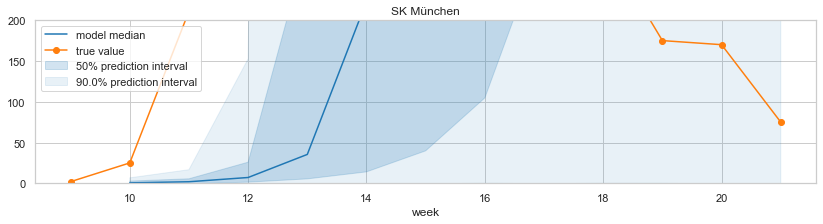

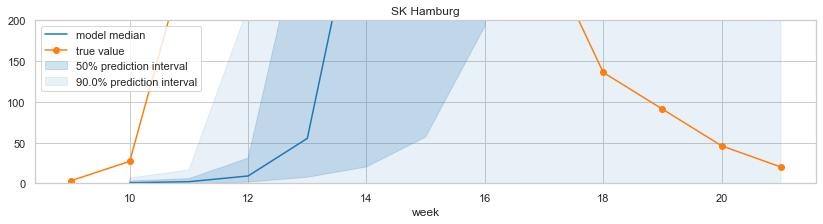

In [33]:
def week_numbers_to_dates(week_numbers):
    return weeks_ending.loc[week_numbers]


def plot_sample_with_quantiles(sample_values, alpha=0.1, label=None, ax=None, color='C0'):
    if ax is None:
        plt.figure(figsize=(14, 3))
        ax = plt.gca()
    plot_with_q = sample_values.apply(pd.Series.quantile, q=[alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2]).T

    if label is None:
        label = 'model'
    plot_with_q[0.5].plot(ax=ax, label=label+' median', color=color)
    ax.fill_between(plot_with_q.index,
                     plot_with_q[0.25],
                     plot_with_q[0.75], 
                     alpha=0.2,
                     label=f'50% prediction interval',
                     color=color)
    ax.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label=f'{100 * (1 - alpha)}% prediction interval',
                     color=color)

def sanity_check(true_values=None, obs_var_name='obs'):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=1000, model=model, vars=[obs_var_name])[obs_var_name]
    reported_cases = xr.DataArray(y, 
                              dims=('draw', 'week', 'l_a'), 
                              coords={
                                  'draw': range(1000),
                                  'week': cases.index[1:],
                                  'l_a': cases.columns
                              })
    # draw, week, Landkreis
    county_cases = reported_cases.unstack().mean(dim='Altersgruppe')
    # observed cases
    grouped_cases = cases.groupby(level=0, axis=1).sum()
    
    for county in sel_counties[:2]:
        one_county_cases = county_cases.sel({'Landkreis': county}) \
                                       .to_dataframe('expected_cases')['expected_cases'].unstack()
        plot_sample_with_quantiles(one_county_cases)
        grouped_cases[county].plot(label='true value', marker='o', color='C1')
        plt.title(county)
        plt.ylim([0, 2e2])
        plt.legend(loc='upper left')
    return y
    

# And run the sanity check
y = sanity_check(cases, 'reported_cases')

In [34]:
with model:
    #print(model.test_point)
    trace = pm.sample(init='adapt_diag')
    #trace = pm.sample(10000, tune=5000, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [case_rep_rate_factors_l, rep_rate_change_over_time, case_rep_rate_zero_l, case_rep_rate_zero, start_inf_l_a, start_inf_l_a_simga, start_inf_l, start_inf_l_sigma, start_inf_l_mu, r_la_delta, r_la_delta_sigma, r_l_delta, r_l_delta_sigma, r_l_delta_mu, r_la_zero_inner, r_la_zero_sigma, r_l_zero, r_l_zero_sigma, r_l_zero_mu]
Sampling 4 chains, 2,000 divergences: 100%|██████████| 4000/4000 [00:49<00:00, 81.45draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.4165722538197601, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.7109164238768

### Add labels to model output

In [35]:
r_zero_and_deltas = np.concatenate([trace['r_l_zero_mu'].reshape(-1,1), trace['r_l_delta_mu']], axis=1)
model_r = pd.DataFrame(r_zero_and_deltas.cumsum(axis=1), columns=cases[:-1].index) + 1

r_l_zero_and_deltas = np.concatenate([trace['r_l_zero'][:,:, None], trace['r_l_delta']], axis=2)
model_r_l = r_l_zero_and_deltas.cumsum(axis=2) + 1
model_r_l = xr.DataArray(model_r_l,
                              dims=('draw', 'Landkreis', 'week'),
                              coords={
                                  'week': cases[:-1].index,
                                  'Landkreis': cases.columns.get_level_values(0).drop_duplicates()
                          })

r_la_zero_and_deltas = np.concatenate([trace['r_la_zero_inner'][:,:,:, None], trace['r_la_delta']], axis=3)
model_r_la = r_la_zero_and_deltas.cumsum(axis=3) + 1
model_r_la = xr.DataArray(model_r_la,
                          dims=('draw', 'Altersgruppe', 'Landkreis', 'week'),
                          coords={
                              'Altersgruppe': age_groups, 
                              'Landkreis': sel_counties,
                              'week': cases[:-1].index,
                          })


model_start_indections = xr.DataArray(trace['start_inf_l_a'],
                                      dims=('draw', 'Altersgruppe', 'Landkreis'), 
                                      coords={
                                          'Altersgruppe': age_groups, 
                                          'Landkreis': sel_counties,
                                      }).unstack()

infections = xr.DataArray(np.exp(trace['log_infections']),
                          dims=('draw', 'week', 'l_a'), 
                          coords={
                              'week': cases.index,
                              'l_a': cases.columns
                          }).unstack()

model_cases = xr.DataArray(trace['expected_cases'][:,:, :], 
                           dims=('draw', 'week', 'l_a'), 
                           coords={
                               'week': cases.index,
                               'l_a': cases.columns
                           }).unstack()

model_case_reporting_rates = xr.DataArray(trace['case_rep_rates'][:,:,:], 
                                          dims=('draw', 'week', 'l_a'), 
                                          coords={
                                              'week': cases.index[1:],
                                              'l_a': cases.columns
                                          }).unstack()

model_reported_cases = trace['expected_cases'][:,1:, :] * trace['case_rep_rates'][:,:,:]
model_reported_cases = xr.DataArray(model_reported_cases, 
                                    dims=('draw', 'week', 'l_a'), 
                                    coords={
                                        'week': cases.index[1:],
                                        'l_a': cases.columns
                                    }).unstack()

model_deaths = xr.DataArray(trace['expected_deaths'][:,:, :], 
                            dims=('draw', 'week', 'l_a'), 
                            coords={
                                'week': cases.index,
                                'l_a': cases.columns
                            }).unstack()

county_model_cases = model_cases.sum(dim='Altersgruppe')
county_model_reported_cases = model_reported_cases.sum(dim='Altersgruppe')
county_cases = cases.groupby(level=0, axis=1).sum()
county_deaths = deaths.groupby(level=0, axis=1).sum()

## Plot Model against Data

### Plot Totals

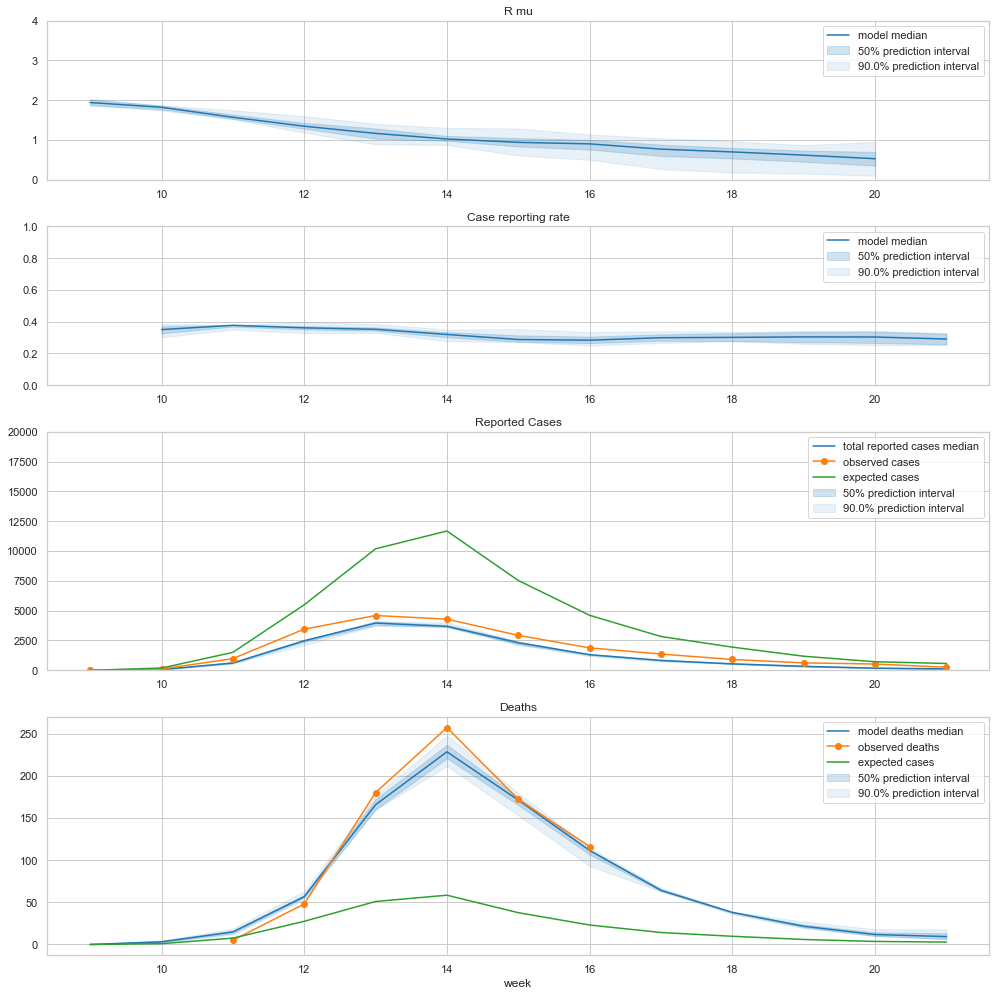

In [36]:
rows = 4
fig, axes = plt.subplots(rows, 1,
                         gridspec_kw={'height_ratios': [2,2,3,3]},
                         figsize=(14, 14), sharex=True)

plot_sample_with_quantiles(model_r, ax=axes[0])
axes[0].set_title('R mu')
axes[0].set_ylim([0, 4])
axes[0].legend()


rep_rates = model_case_reporting_rates.median(dim=['Landkreis', 'Altersgruppe']) \
                                      .to_dataframe('case_reporting_rate')['case_reporting_rate'] \
                                      .unstack()
plot_sample_with_quantiles(rep_rates, ax=axes[1])
axes[1].legend(loc='upper right')
axes[1].set_ylim([0, 1])
axes[1].set_title('Case reporting rate')


total_reported_cases = model_reported_cases.sum(dim=['Altersgruppe', 'Landkreis']) \
                                           .to_dataframe('expected_cases')['expected_cases'] \
                                           .unstack()
plot_sample_with_quantiles(total_reported_cases, label='total reported cases', ax=axes[2], color='C0')
cases.stack(level=[0,1]) \
     .groupby('week') \
     .sum() \
     .plot(label='observed cases', ax=axes[2], marker='o', color='C1')
model_cases.sum(dim=['Altersgruppe', 'Landkreis']) \
           .to_dataframe('expected_cases')['expected_cases'] \
           .unstack() \
           .median() \
           .plot(ax=axes[2], color='C2', label='expected cases')
axes[2].set_title('Reported Cases')
axes[2].set_ylim([0, 2e4])
axes[2].legend(loc='upper right')


total_model_deaths = model_deaths.sum(dim=['Altersgruppe', 'Landkreis']) \
                           .to_dataframe('expected_cases')['expected_cases'] \
                           .unstack()
plot_sample_with_quantiles(total_model_deaths, label='model deaths', ax=axes[3], color='C0')
deaths.stack(level=[0,1]) \
      .groupby('week') \
      .sum() \
      .plot(label='observed deaths', ax=axes[3], marker='o', color='C1')
to_plot = model_cases.sum(dim=['Altersgruppe', 'Landkreis']) \
                     .to_dataframe('expected_cases')['expected_cases'] \
                     .unstack() \
                     .median() / 200
to_plot.plot(ax=axes[3], color='C2', label='expected cases')
axes[3].set_title('Deaths')
axes[3].legend(loc='upper right')



for i in range(rows):
     axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()

## Plot Age Groups

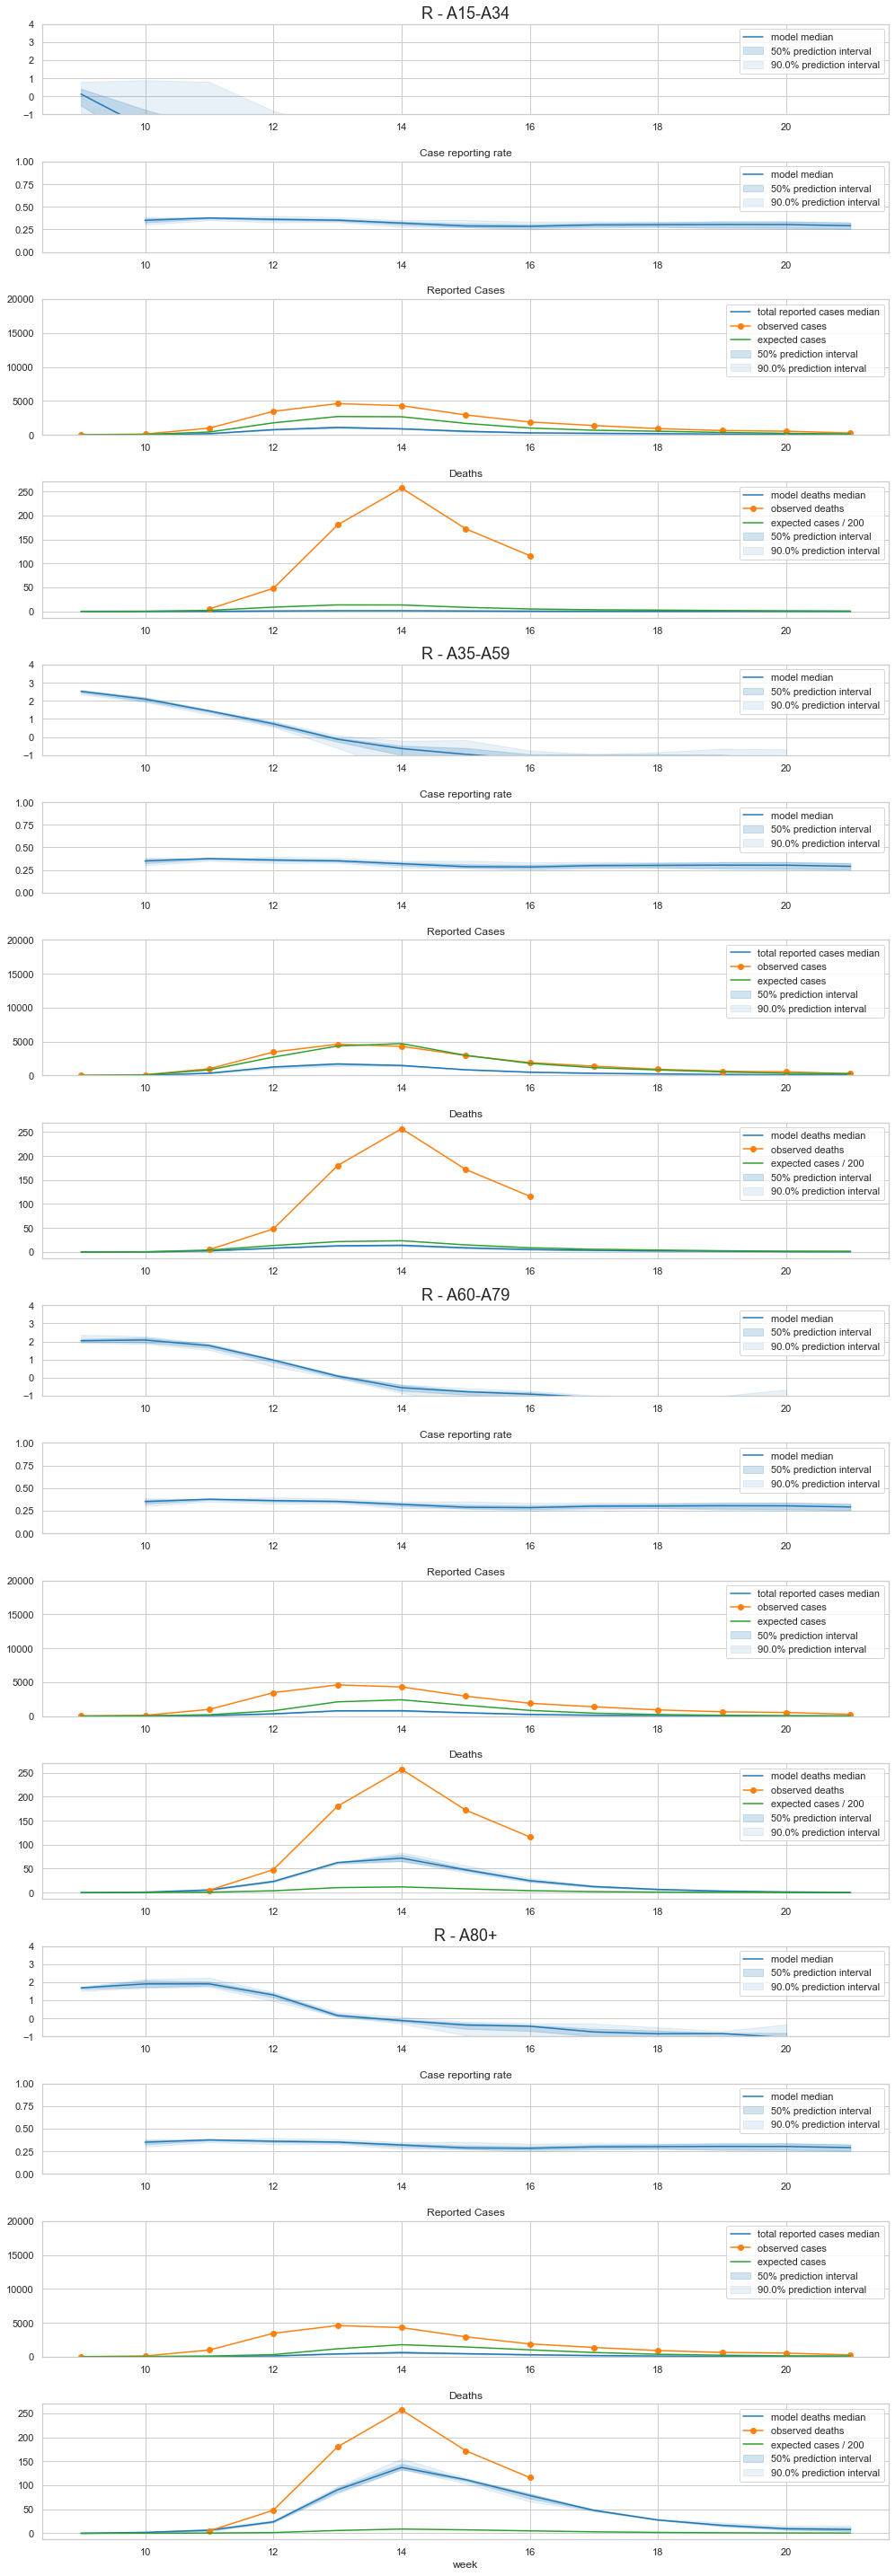

In [41]:
rows = 4 * n_age_groups
fig, axes = plt.subplots(rows, 1,
                         gridspec_kw={'height_ratios': [2, 2, 3, 3] * n_age_groups},
                         figsize=(14, 10 * n_age_groups), sharex=True)

i = 0
for one_age_group in age_groups:
    r_age_group = model_r_la.median('Landkreis') \
                            .sel({'Altersgruppe': one_age_group}) \
                            .to_dataframe('r_age_group')['r_age_group'] \
                            .unstack()
    plot_sample_with_quantiles(r_age_group, ax=axes[i])
    axes[i].set_title(f'R - {one_age_group}', fontsize=18)
    axes[i].set_ylim([-1, 4])
    axes[i].yaxis.set_major_locator(MultipleLocator(1))
    axes[i].legend()
    i += 1

    rep_rates = model_case_reporting_rates.median(dim=['Landkreis']) \
                                          .sel({'Altersgruppe': one_age_group}) \
                                          .to_dataframe('case_reporting_rate')['case_reporting_rate'] \
                                          .unstack()
    plot_sample_with_quantiles(rep_rates, ax=axes[i])
    axes[i].legend(loc='upper right')
    axes[i].set_ylim([0, 1])
    axes[i].set_title('Case reporting rate')
    i += 1

    total_reported_cases = model_reported_cases.sum(dim=['Landkreis']) \
                                               .sel({'Altersgruppe': one_age_group}) \
                                               .to_dataframe('expected_cases')['expected_cases'] \
                                               .unstack()
    plot_sample_with_quantiles(total_reported_cases, label='total reported cases', ax=axes[i], color='C0')
    cases.stack(level=[0,1]) \
         .groupby('week') \
         .sum() \
         .plot(label='observed cases', ax=axes[i], marker='o', color='C1')
    model_cases.sum(dim=['Landkreis']) \
               .sel({'Altersgruppe': one_age_group}) \
               .to_dataframe('expected_cases')['expected_cases'] \
               .unstack() \
               .median() \
               .plot(ax=axes[i], color='C2', label='expected cases')
    axes[i].set_title('Reported Cases')
    axes[i].set_ylim([0, 2e4])
    axes[i].legend(loc='upper right')
    i += 1
    

    total_model_deaths = model_deaths.sum(dim=['Landkreis']) \
                                     .sel({'Altersgruppe': one_age_group}) \
                                     .to_dataframe('expected_cases')['expected_cases'] \
                                     .unstack()
    plot_sample_with_quantiles(total_model_deaths, label='model deaths', ax=axes[i], color='C0')
    deaths.stack(level=[0,1]) \
          .groupby('week') \
          .sum() \
          .plot(label='observed deaths', ax=axes[i], marker='o', color='C1')
    to_plot = model_cases.sum(dim=['Landkreis']) \
                         .sel({'Altersgruppe': one_age_group}) \
                         .to_dataframe('expected_cases')['expected_cases'] \
                         .unstack() \
                         .median() / 200
    to_plot.plot(ax=axes[i], color='C2', label='expected cases / 200')
    axes[i].set_title('Deaths')
    axes[i].legend(loc='upper right')
    i += 1


for i in range(rows):
     axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()

## Plot Counties

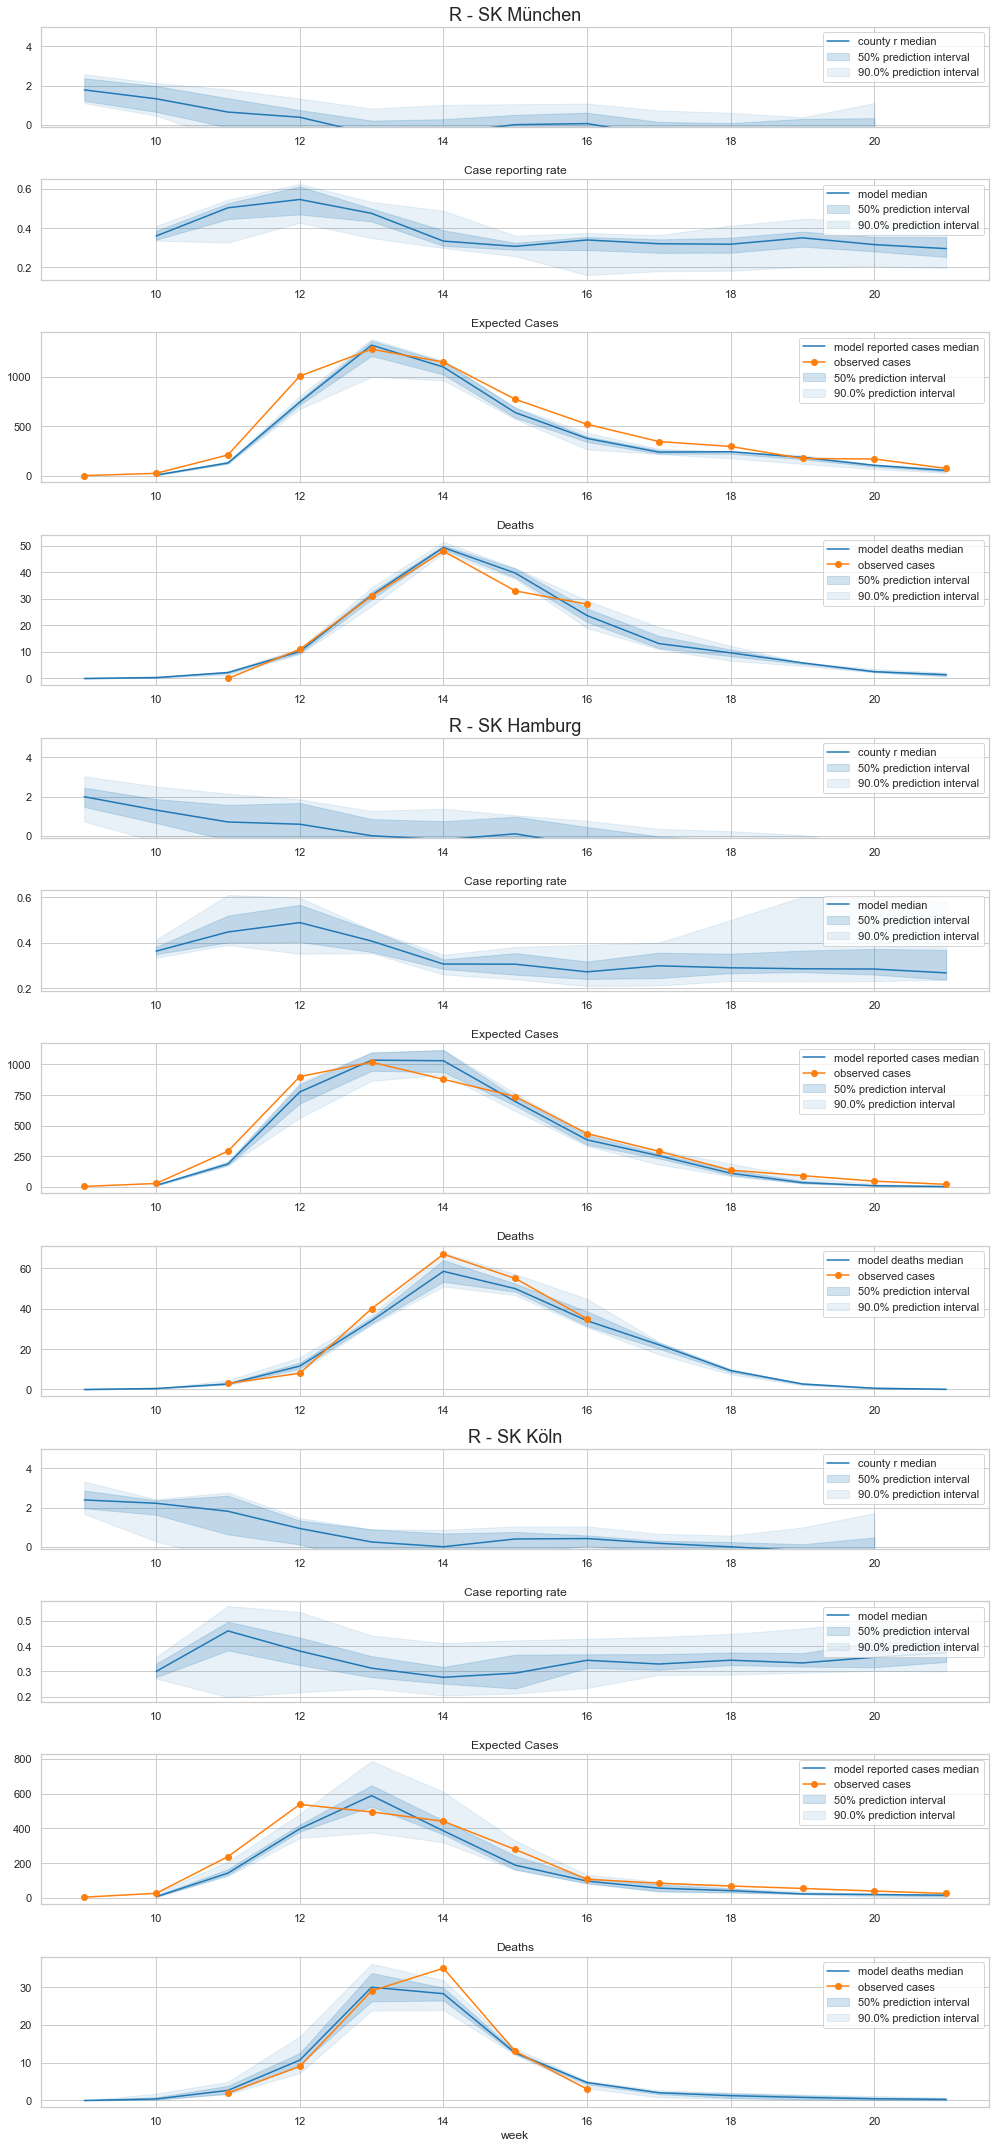

In [42]:
n_plot_counties = 3
fig, axes = plt.subplots(n_plot_counties * 4, 1,
                         gridspec_kw={'height_ratios': [2, 2, 3, 3] * n_plot_counties},
                         figsize=(14, n_plot_counties * 10), sharex=True)

i = 0
for county in sel_counties[:n_plot_counties]:   
    county_r = model_r_l.sel({'Landkreis': county}) \
                        .to_dataframe('r_l')['r_l'] \
                        .unstack()
    plot_sample_with_quantiles(county_r, label='county r', ax=axes[i])
    axes[i].set_title(f'R - {county}', fontsize=18)
    axes[i].set_ylim([-0.1, 5])
    axes[i].legend()
    i += 1

    rep_rates = model_case_reporting_rates.median(dim=['Altersgruppe']) \
                                          .sel({'Landkreis': county}) \
                                          .to_dataframe('case_reporting_rate')['case_reporting_rate'] \
                                          .unstack()
    plot_sample_with_quantiles(rep_rates, ax=axes[i])
    axes[i].legend(loc='upper right')
    #axes[i].set_ylim([0, 1.5])
    axes[i].set_title('Case reporting rate')
    i += 1
    
    #     county_inf = infections.sel({'Landkreis': county}) \
    #                            .sum(dim='Altersgruppe') \
    #                            .to_dataframe('infections')['infections'] \
    #                            .unstack()
    #     plot_sample_with_quantiles(county_inf, label='infections', ax=axes[i])
    #     axes[i].set_title(f'Infections {county}')
    #     axes[i].set_ylim([0, 200])
    #     i += 1

    one_group_model_reported_cases = county_model_reported_cases.sel({'Landkreis': county}) \
                                                                .to_dataframe('expected_cases')['expected_cases'] \
                                                                .unstack()
    plot_sample_with_quantiles(one_group_model_reported_cases, label='model reported cases', ax=axes[i])
    county_cases[county].plot(label='observed cases', ax=axes[i], marker='o', color='C1')

    #     one_group_model_cases = county_model_cases.sel({'Landkreis': county}) \
    #                                               .to_dataframe('expected_cases')['expected_cases'] \
    #                                               .unstack()
    #     plot_sample_with_quantiles(one_group_model_cases, label='model cases', ax=axes[i], color='C2')
    axes[i].set_title(f'Expected Cases')
    #axes[i].set_ylim([0, 500])
    axes[i].legend()
    i += 1

    one_group_model_deaths = model_deaths.sum('Altersgruppe') \
                                         .sel({'Landkreis': county}) \
                                         .to_dataframe('expected_cases')['expected_cases'] \
                                         .unstack()
    plot_sample_with_quantiles(one_group_model_deaths, label='model deaths', ax=axes[i])
    county_deaths[county].plot(label='observed cases', ax=axes[i], marker='o', color='C1')


    axes[i].set_title(f'Deaths')
    #axes[i].set_ylim([0, 35])
    axes[i].legend()
    i += 1
    
for j in range(i):
     axes[j].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()

## Plot Age Groups in Counties

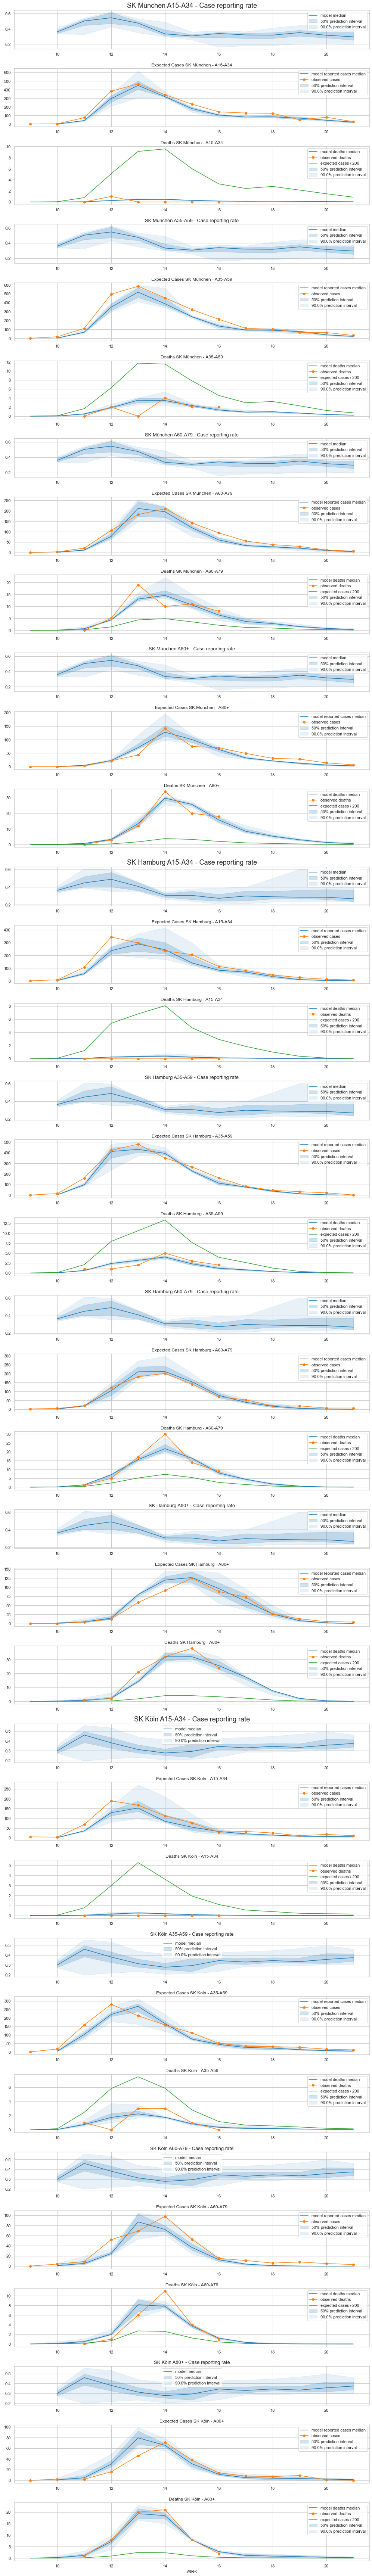

In [39]:
n_plot_counties = 3
fig, axes = plt.subplots(3 * n_plot_counties * n_age_groups, 1,
                         gridspec_kw={'height_ratios': [2, 3, 3] * n_plot_counties * n_age_groups},
                         figsize=(14, n_plot_counties * n_age_groups * 8), sharex=True) 

i = 0
for county in sel_counties[:n_plot_counties]:
    first_in_county = True
    for age_group in model_reported_cases.indexes['Altersgruppe']:
        if first_in_county:
            font_size = 18
            first_in_county = False
        else:
            font_size = 13
        
        rep_rates = model_case_reporting_rates.sel({'Landkreis': county, 'Altersgruppe': age_group}) \
                                              .to_dataframe('case_reporting_rate')['case_reporting_rate'] \
                                              .unstack()
        plot_sample_with_quantiles(rep_rates, ax=axes[i])
        axes[i].legend(loc='upper right')
        # axes[i].set_ylim([0, 1.5])
        axes[i].set_title(f'{county} {age_group} - Case reporting rate', fontsize=font_size)
        i += 1
        
        one_group_cases = model_reported_cases.sel({'Landkreis': county, 'Altersgruppe': age_group}) \
                                              .to_dataframe('expected_cases')['expected_cases'].unstack()
        plot_sample_with_quantiles(one_group_cases, label='model reported cases', ax=axes[i])
        cases[county, age_group].plot(label='observed cases', ax=axes[i], marker='o', color='C1')
        axes[i].set_title(f'Expected Cases {county} - {age_group}')
        i += 1
        
        one_group_deaths = model_deaths.sel({'Landkreis': county, 'Altersgruppe': age_group}) \
                                              .to_dataframe('deaths')['deaths'].unstack()
        plot_sample_with_quantiles(one_group_deaths, label='model deaths', ax=axes[i])
        deaths[county, age_group].plot(label='observed deaths', ax=axes[i], marker='o', color='C1')
        
        axes[i].set_title(f'Deaths {county} - {age_group}')
        
        i += 1
    

for j in range(i):
    axes[j].xaxis.set_tick_params(which='both', labelbottom=True)
    axes[j].legend()
plt.tight_layout()

KeyboardInterrupt: 

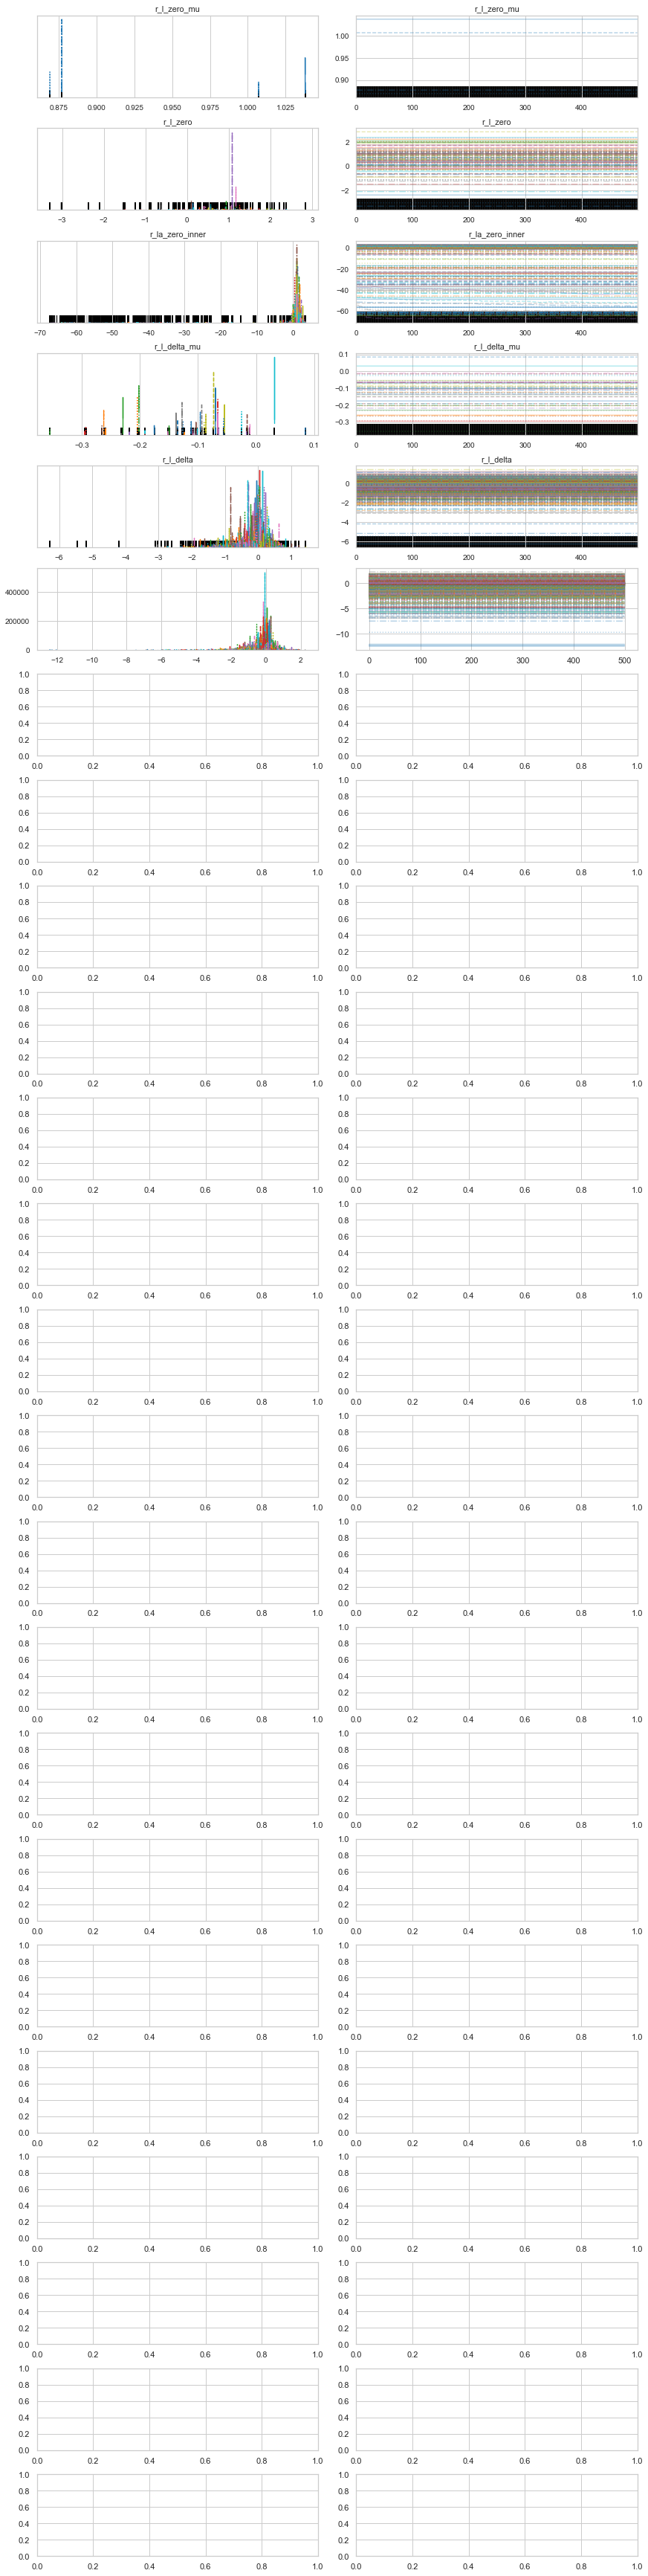

In [40]:
_ = pm.traceplot(trace)

In [ ]:
posterior = pm.sample_posterior_predictive(trace, model=model)

## Distribution Playground

In [ ]:
with pm.Model():
    a = pm.Gamma('a', mu=1, sigma=.3).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 3, 0.05))
    print(a.min(), a.max())

In [ ]:
with pm.Model():
    a = pm.Gamma('a', mu=0.2, sigma=0.1).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 0.5, 0.01))
    print(a.min(), a.max())

## Theano Playground

In [ ]:
import theano
x = theano.tensor.fvector('x')
x.tag.test_value = np.random.rand(2).astype(np.float32)
W = theano.shared(np.asarray([0.2, 0.7]), 'W')
y = (x * W).sum()
 
f = theano.function([x], y)
output = f([1.0, 1.0])
print(output)

In [ ]:
x